In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import sklearn.metrics as skmet
from sklearn.metrics.pairwise import euclidean_distances, rbf_kernel, linear_kernel
from sklearn.decomposition import TruncatedSVD, KernelPCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import auc, roc_curve
from nlputils.features import FeatureTransform, features2mat
from datasets.cancer_papers.load_cancer import articles2dict
from visualize_relevantwords import select_subset
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# load cancer abstracts with keywords as labels
textdict, doccats, _ = articles2dict(label='keyword', ignore_types=['Introduction', 'Discussion',
                                                                    'Mixed', 'Methods', 'Results'], verbose=0)

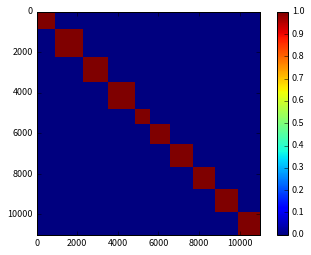

In [3]:
# check the true labels
doc_ids = sorted(doccats.keys(), key=doccats.get)
y = [doccats[did] for did in doc_ids]
Y = np.tile(y, (len(y), 1))
plt.figure()
plt.imshow(np.array(Y==Y.T, dtype=float), interpolation='nearest')
plt.colorbar()

In [4]:
def get_auc(sim_scores, diss_scores):
    labels = np.hstack((np.array(sim_scores), np.array(diss_scores)))
    true_labels = np.hstack((np.ones(len(sim_scores)), np.zeros(len(diss_scores))))
    fpr, tpr, thresholds = roc_curve(true_labels, labels, pos_label=1)
    auc_val = auc(fpr, tpr)
    return auc_val

def plot_sim_dist(sim_scores, diss_scores):
    """
    compare the distribution of similarity scores for documents that should be similar to each other and those that shouldn't
    Input:
        - sim_scores: an array with similarity scores of supposable similar documents 
        - diss_scores: an array with similarity scores of supposable not similar documents 

    The function creates a histogram with two distributions (similarity scores for similar and dissimilar documents)
    to see how well the chosen similarity coefficient is able to distinguish between the two kinds of documents
    """
    # get auc values (change it up since we're dealing with distances, not similarities)
    auc_score = get_auc(diss_scores, sim_scores)
    # plot distributions - histograms
    minval = min(min(sim_scores), min(diss_scores))
    maxval = max(max(sim_scores), max(diss_scores))
    plt.figure()
    plt.hist(sim_scores, bins=120, color='b', normed=True, histtype='step', label='similar docs')
    plt.hist(diss_scores, bins=120, color='r', normed=True, histtype='step', label='dissimilar docs')
    plt.xlim(minval, maxval)
    plt.legend(loc=1)
    plt.title('Similarity score distributions (AUC: %.4f)' % auc_score)
    plt.xlabel('Score')

def compare_scores(D):
    Y = np.tile(y, (len(y), 1))
    L = np.array(Y==Y.T, dtype=int)
    sim_scores = D[L == 1].flatten()
    diss_scores = D[L == 0].flatten()
    plot_sim_dist(sim_scores, diss_scores)

def eval_prediction(y_pred):
    Y = np.tile(y_pred, (len(y_pred), 1))
    L_pred = np.array(Y==Y.T, dtype=int)
    # don't count noise as the same cluster
    L_pred[Y==-1] = 0
    plt.figure()
    plt.imshow(L_pred, interpolation='nearest')
    plt.colorbar()
    # check precision/recall
    L_pred = L_pred.flatten()
    Y = np.tile(y, (len(y), 1))
    L = np.array(Y==Y.T, dtype=int).flatten()
    print "Precision: %.3f, Recall: %.3f, Accuracy: %.3f" % (100.*skmet.precision_score(L, L_pred), 100.*skmet.recall_score(L, L_pred), 100.*skmet.accuracy_score(L, L_pred))

euclidean distance
0.504588258785
rbf kernel
linear kernel


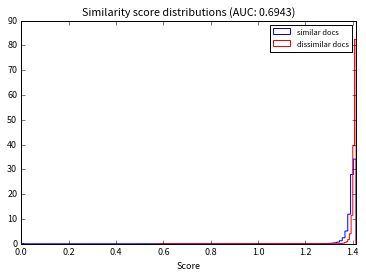

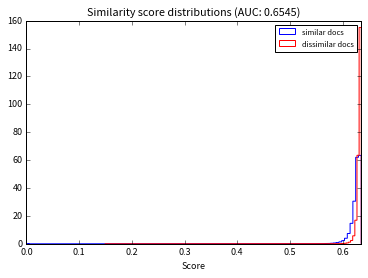

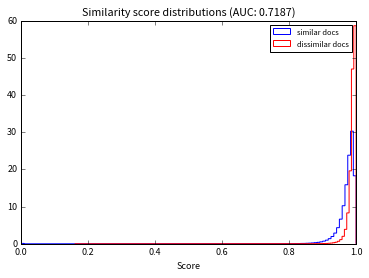

In [5]:
# tf-idf features
ft = FeatureTransform(norm='max', weight=True, renorm='length', norm_num=False)
docfeats = ft.texts2features(textdict)
X, featurenames = features2mat(docfeats, doc_ids)
print "euclidean distance"
D = euclidean_distances(X)
gamma = 1./(np.median(D)**2)
print gamma
compare_scores(D)
print "rbf kernel"
D = rbf_kernel(X, X, gamma)
compare_scores(np.max(D) - D)
print "linear kernel"
D = linear_kernel(X)
compare_scores(np.max(D) - D)

euclidean distance
3.11080480002
rbf kernel
linear kernel


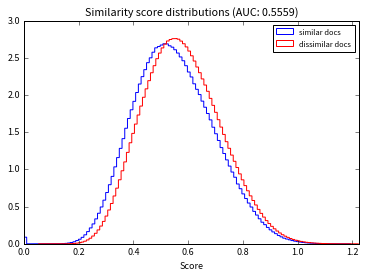

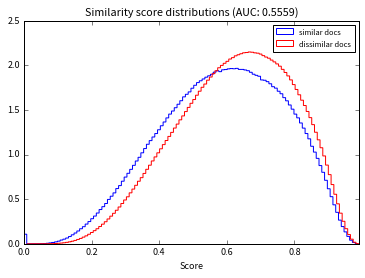

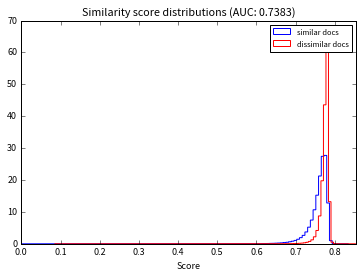

In [6]:
# 250 dim LSA
svd = TruncatedSVD(n_components=250, n_iter=7, random_state=42)
X_red = svd.fit_transform(X)
print "euclidean distance"
D = euclidean_distances(X_red)
gamma = 1./(np.median(D)**2)
print gamma
compare_scores(D)
print "rbf kernel"
D = rbf_kernel(X_red, X_red, gamma)
compare_scores(np.max(D) - D)
print "linear kernel"
D = linear_kernel(X_red)
compare_scores(np.max(D) - D)

euclidean distance
0.534450786152
rbf kernel
linear kernel


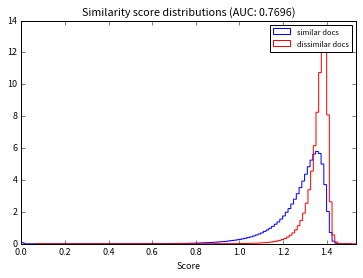

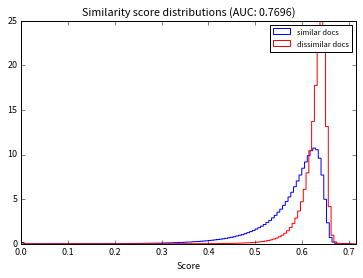

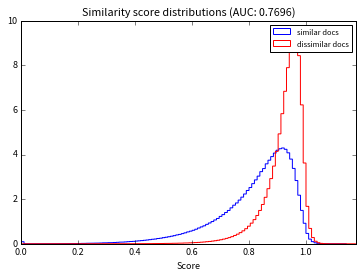

In [7]:
# length normed LSA
xnorm = np.linalg.norm(X_red, axis=1)
X_normed = X_red/xnorm.reshape(X_red.shape[0], 1)
print "euclidean distance"
D = euclidean_distances(X_normed)
gamma = 1./(np.median(D)**2)
print gamma
compare_scores(D)
print "rbf kernel"
D = rbf_kernel(X_normed, X_normed, gamma)
compare_scores(np.max(D) - D)
print "linear kernel"
D = linear_kernel(X_normed)
compare_scores(np.max(D) - D)

euclidean distance
3.10041047849
rbf kernel
linear kernel


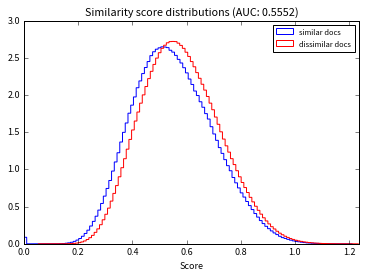

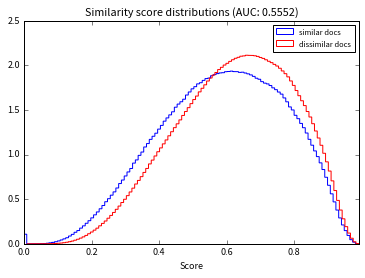

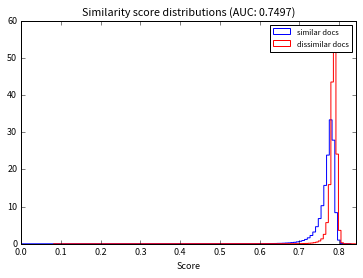

In [8]:
# 250 kpca
e_lkpca = KernelPCA(n_components=250, kernel='linear')
X_red = e_lkpca.fit_transform(X)
print "euclidean distance"
D = euclidean_distances(X_red)
gamma = 1./(np.median(D)**2)
print gamma
compare_scores(D)
print "rbf kernel"
D = rbf_kernel(X_red, X_red, gamma)
compare_scores(np.max(D) - D)
print "linear kernel"
D = linear_kernel(X_red)
compare_scores(np.max(D) - D)

euclidean distance
0.491077436309
rbf kernel
linear kernel


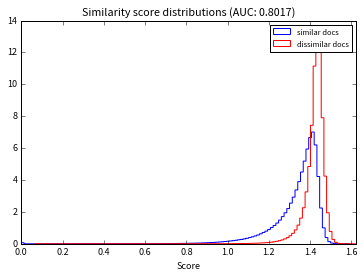

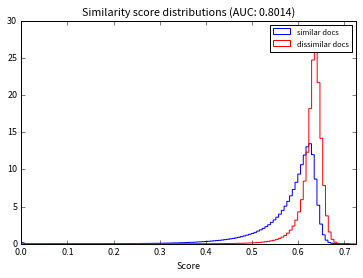

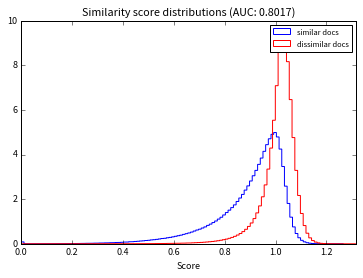

In [9]:
# length normed KPCA
xnorm = np.linalg.norm(X_red, axis=1)
X_normed = X_red/xnorm.reshape(X_red.shape[0], 1)
print "euclidean distance"
D = euclidean_distances(X_normed)
gamma = 1./(np.median(D)**2)
print gamma
compare_scores(D)
print "rbf kernel"
D = rbf_kernel(X_normed, X_normed, gamma)
compare_scores(np.max(D) - D)
print "linear kernel"
D = linear_kernel(X_normed)
compare_scores(np.max(D) - D)

7
Precision: 10.292, Recall: 89.315, Accuracy: 18.881


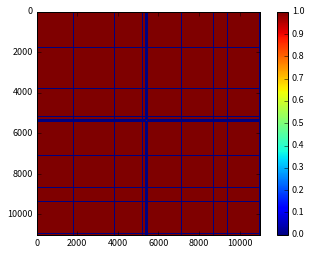

In [11]:
D = 1.-linear_kernel(X_normed)
clst = DBSCAN(eps=0.45, metric='precomputed', min_samples=3)
y_pred = clst.fit_predict(D)
print len(np.unique(y_pred))
eval_prediction(y_pred)